# IRENE

“For those who pass it without entering, the city is one thing; it is another for those who are trapped by it and never leave. There is the city where you arrive for the first time; and there is another city which you leave never to return. Each deserves a different name; perhaps I have already spoken of Irene under other names; perhaps I have spoken only of Irene.”

In [1]:
from __future__ import print_function
from IPython.display import Image

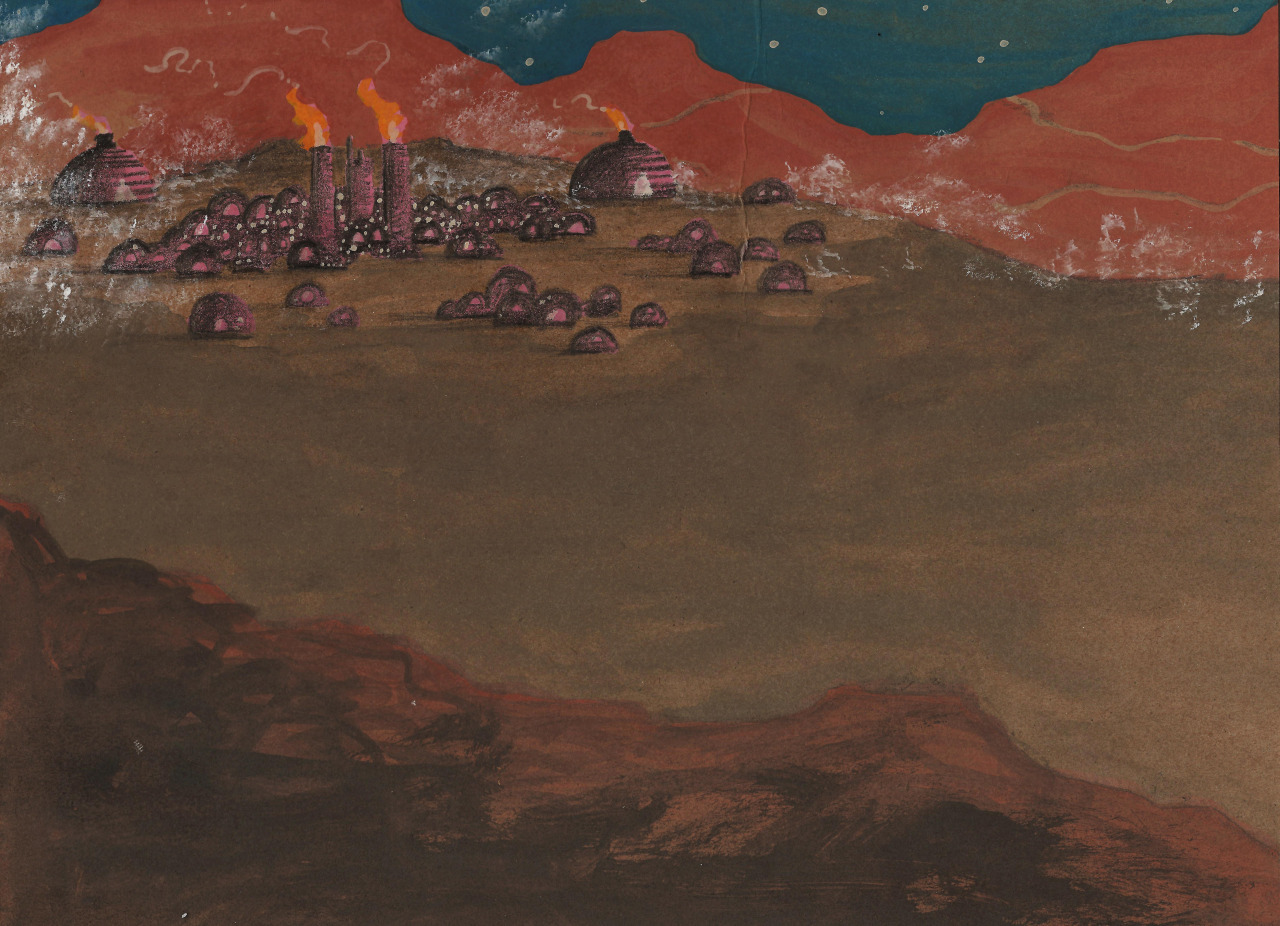

In [2]:
Image(filename='../../../Images/Irene.jpg') 

#### The city of IRENE performs a fast processing directly from raw data (pmtrwf and sipmrwf) to PMAPS. It is optimized for speed (use of CYTHON functions) and intended for fast processing of data at LSC

In [3]:
import time
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
from Database import loadDB
import ICython.Sierpe.BLR as blr
import ICython.Core.peakFunctions as cpf
import Core.peakFunctions as pf
from ICython.Core.system_of_units import SystemOfUnits 
from scipy import signal
%load_ext Cython

In [4]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

11/12/2016
00:39:46


In [5]:
from time import time

### Preproc Steps

1. Deconvolute RWF
2. Compute calibrated sum of PMTs (including MAU threshold)
3. Zero Suppression (ZS) in PMTs
4. S1 search (analysis specific)
5. S2 search (analysis specific) and rebin
6. ZS in SiPMs
7. Select S2 in ZS SiPMs 

For fast pre-proc, all the above steps must be computed on the fly (e.g, minimal access to disk) and
using pre-compiled (cython) functions in calculation-intensive parts (loops)

### Test data

In [73]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'
ffile = 'run_2976.gdc1next.000.next1el_2976.root.h5'
r2976 = tb.open_file(path+ffile,'r+')
pmtrwf = r2976.root.RD.pmtrwf
sipmrwf = r2976.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 91
        Number of PMTs = 12
        PMTWL = 48000
        Number of SiPMs = 1792
        SiPMWL = 1200
      


### Access to data base and definition of units

In [74]:
DataPMT = loadDB.DataPMT(2976)
units = SystemOfUnits()
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = loadDB.DataSiPM(2976)
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [75]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


In [76]:
DataSiPM.head()

,SensorID,ChannelID,Active,X,Y,adc_to_pes
0,1000,1025,1,-235.0,45.0,16.5000
1,1001,1024,1,-235.0,55.0,15.6993
2,1002,1027,1,-235.0,65.0,17.5702
3,1003,1026,1,-235.0,75.0,16.1821
4,1004,1016,1,-235.0,85.0,17.1369


### Deconvolution

run over 0 events  in 0.159602165222 s


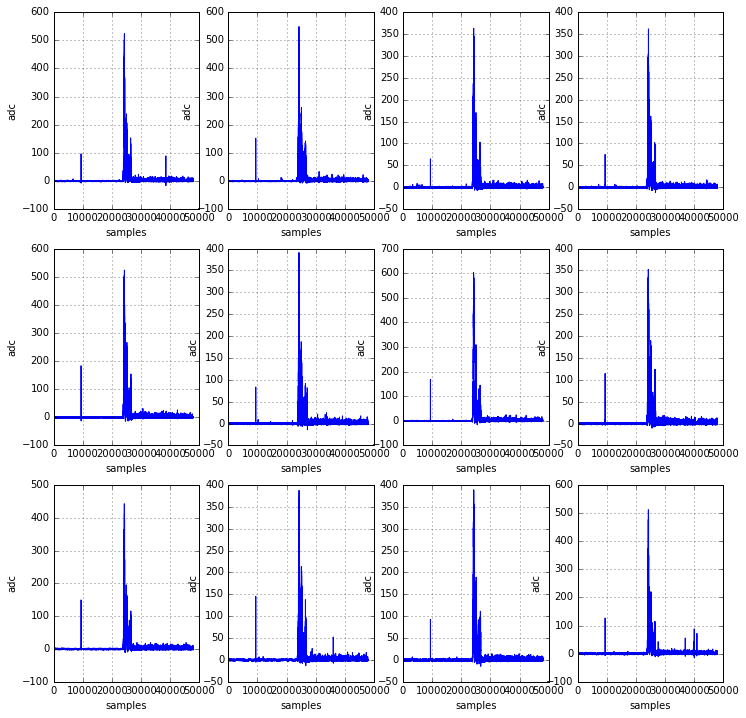

In [77]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))
mpl.plot_waveforms(CWF)

In [ ]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

### calibrated PMT sum

In [78]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))

run over 0 events  in 0.185168027878 s


In [79]:
tstep = 25
signal_t = np.arange(0., PMTWL * tstep, tstep)

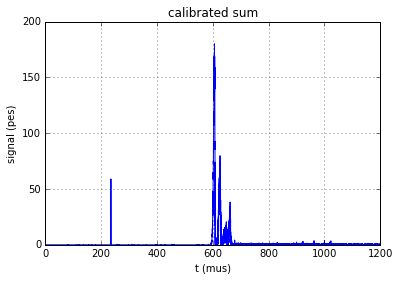

In [80]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

###  ZS in PMTs

In [81]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
t1 = time()        
dt = t1 - t0

print("run over {} events  in {} s".format(event,dt))

run over 0 events  in 0.199944019318 s


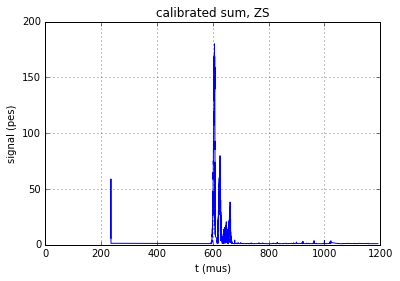

In [15]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum, ZS",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

### Find S12 

In [89]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

In [90]:
S1

{0: [array([ 235000.,  235025.,  235050.,  235075.,  235100.,  235125.,
          235150.,  235175.,  235200.,  235225.,  235250.,  235275.,
          235300.,  235325.,  235350.]),
  array([  5.93195043,  21.03559257,  40.95658474,  56.01525993,
          58.98818919,  51.01282834,  37.66093463,  25.33503027,
          16.29579392,  11.4940765 ,   7.50042533,   5.57756861,
           3.09133606,   2.63786589,   1.49142167])]}

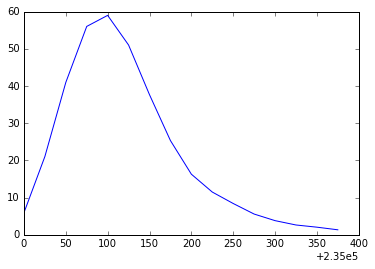

In [84]:
plt.plot(S1[0][0],S1[0][1])

#### Structure of S1/S2
1. Dictionary index counts the number of peaks
2. Dict values are a list [T,E], where T and E are numpy arrays of Time and Energy

In [85]:
S1

{0: [array([ 235000.,  235025.,  235050.,  235075.,  235100.,  235125.,
          235150.,  235175.,  235200.,  235225.,  235250.,  235275.,
          235300.,  235325.,  235350.,  235375.]),
  array([  5.93195043,  21.03559257,  40.95658474,  56.01525993,
          58.98818919,  51.01282834,  37.66093463,  25.33503027,
          16.29579392,  11.4940765 ,   8.41424812,   5.57756861,
           3.80647233,   2.63786589,   2.04863497,   1.3435522 ])]}

In [91]:
S2

{0: [array([ 595802.5    ,  597062.5    ,  598062.5    ,  599062.5    ,
          600062.5    ,  601062.5    ,  602062.5    ,  603062.5    ,
          604062.5    ,  605062.5    ,  606062.5    ,  607062.5    ,
          608082.5    ,  609693.125  ,  613720.625  ,  615504.375  ,
          616621.25   ,  617637.5    ,  618637.5    ,  619637.5    ,
          620637.5    ,  621637.5    ,  622637.5    ,  623637.5    ,
          624637.5    ,  625637.5    ,  626637.5    ,  627646.25   ,
          628721.25   ,  629940.     ,  631615.     ,  633595.625  ,
          635035.625  ,  636162.5    ,  637162.5    ,  638162.5    ,
          639162.5    ,  640162.5    ,  641162.5    ,  642162.5    ,
          643162.5    ,  644162.5    ,  645162.5    ,  646162.5    ,
          647162.5    ,  648162.5    ,  649162.5    ,  650162.5    ,
          651162.5    ,  652197.5    ,  653236.25   ,  654270.625  ,
          655310.     ,  656381.25   ,  657412.5    ,  658412.5    ,
          659412.5    ,  660412

number of peaks = 1
S12 number = 0, samples = 15 sum in pes =345.024858109


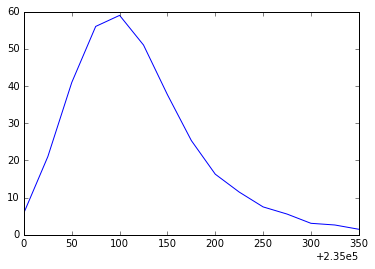

hit return


In [92]:
pf.scan_S12(S1)

number of peaks = 1
S12 number = 0, samples = 64 sum in pes =58341.4039193


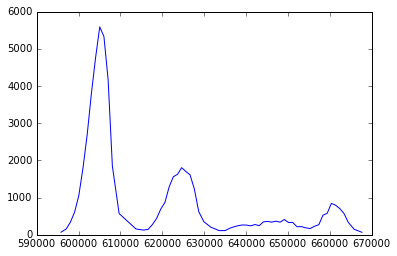

hit return


In [93]:
pf.scan_S12(S2)

### Calibrated PMT sum. Choosing the MAU length

#### PMT sum algorithm
1. Starts a MAU, with length n_MAU in each of the PMTs. The MAU filters the signal in each PMT, which has already been corrected by basline by the deconvolution algorithm. As a result, the MAU follows the signal, averaging it in windows of n_MAU.
2. For each PMT, a given sample is accepted only if above the MAU (threshold is tipically a few adc counts). Thi eliminates low frequency oscillation. 
3. One has to be careful, however, to choose a MAU length short enough, so that it does not average the low frequency oscillation and a threshold small enough not to cut the waveform.
4. This is shown in the example

#### Calibrated pmt sum algorithm (modified to return the MAU and the PMT waveform)

In [98]:
%%cython
cimport numpy as np
import numpy as np
from scipy import signal

cpdef calibrated_pmt_sum(double [:, :] CWF,
                         double [:] adc_to_pes,
                         int n_MAU=200,
                         double thr_MAU=5):
    """
    Computes the ZS calibrated sum of the PMTs
    after correcting the baseline with a MAU to suppress low frequency noise.
    input:
    CWF:    Corrected waveform (passed by BLR)
    adc_to_pes: a vector with calibration constants
    n_MAU:  length of the MAU window
    thr_MAU: treshold above MAU to select sample

    """

    cdef int j, k
    cdef int NPMT = CWF.shape[0]
    cdef int NWF = CWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype=np.double)*(1./float(n_MAU))


    # CWF if above MAU threshold
    cdef double [:, :] pmt_thr = np.zeros((NPMT,NWF), dtype=np.double)
    cdef double [:, :] MAU_disp = np.zeros((NPMT,NWF), dtype=np.double)
    cdef double [:] csum = np.zeros(NWF, dtype=np.double)
    cdef double [:] MAU_pmt = np.zeros(NWF, dtype=np.double)

    for j in range(NPMT):
        # MAU for each of the PMTs, following the waveform
        MAU_pmt = signal.lfilter(MAU,1,CWF[j,:])

        for k in range(NWF):
            MAU_disp[j,k] =  MAU_pmt[k]
            if CWF[j,k] > MAU_pmt[k] + thr_MAU:
                pmt_thr[j,k] = CWF[j,k]

    for j in range(NPMT):
        for k in range(NWF):
            csum[k] += pmt_thr[j, k]*1./adc_to_pes[j]
    return np.asarray(csum), np.asarray(MAU_disp), np.asarray(pmt_thr) 


### Running local (nb) version of CSUM, to ilustrate effect of MAU

#### Run 1: n_MAU=100, thr_MAU=5

In [120]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum, MAU, pmt_thr = calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

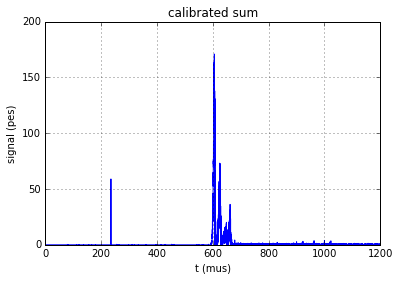

In [121]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=1200, 
                ymax = 200, 
                t_units='mus', units="pes")

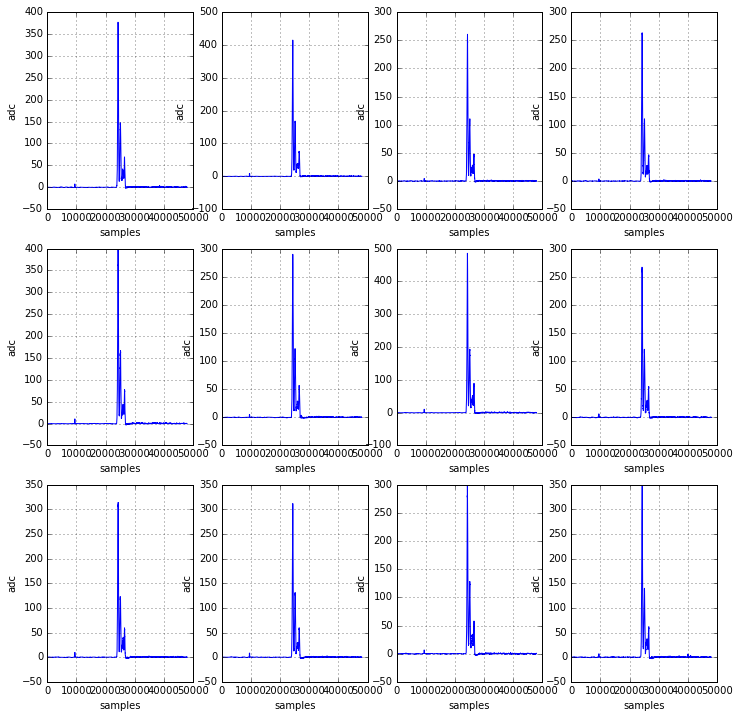

In [122]:
mpl.plot_waveforms(MAU)

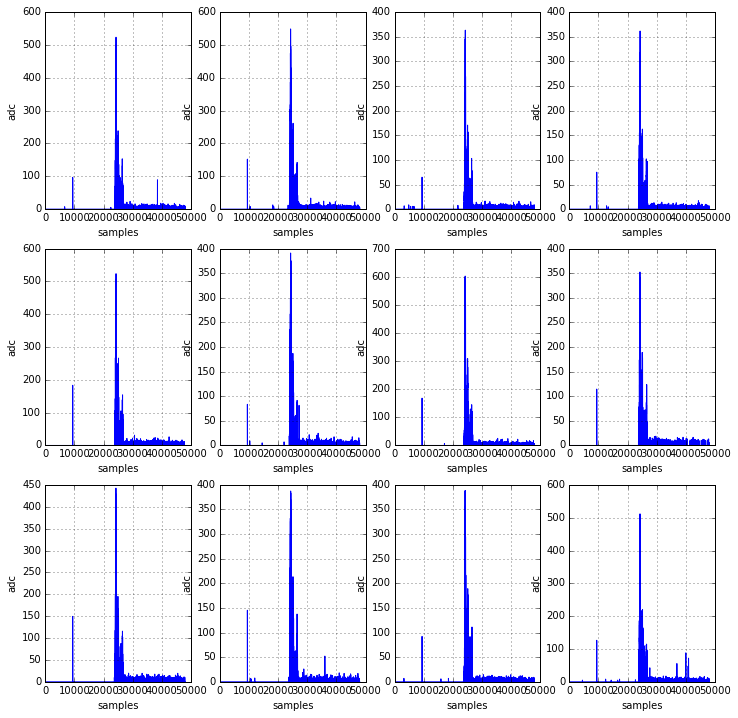

In [123]:
mpl.plot_waveforms(pmt_thr)

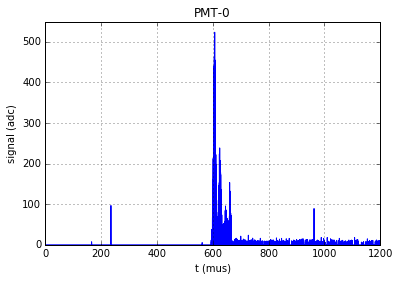

In [124]:
mpl.plot_signal(signal_t/units.mus, pmt_thr[0], title="PMT-0",
                signal_start=0, signal_end=1200, 
                ymax = 550, 
                t_units='mus', units="adc")

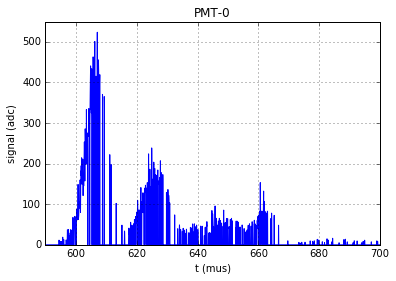

In [125]:
mpl.plot_signal(signal_t/units.mus, pmt_thr[0], title="PMT-0",
                signal_start=590, signal_end=700, 
                ymax = 550, 
                t_units='mus', units="adc")

#### NB: there are holes in the waveform, associated with the thr condition. 

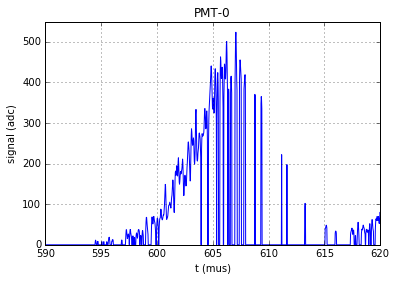

In [126]:
mpl.plot_signal(signal_t/units.mus, pmt_thr[0], title="PMT-0",
                signal_start=590, signal_end=620, 
                ymax = 550, 
                t_units='mus', units="adc")

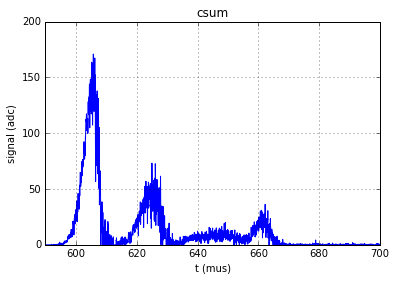

In [128]:
mpl.plot_signal(signal_t/units.mus, csum, title="csum",
                signal_start=590, signal_end=700, 
                ymax = 200, 
                t_units='mus', units="adc")

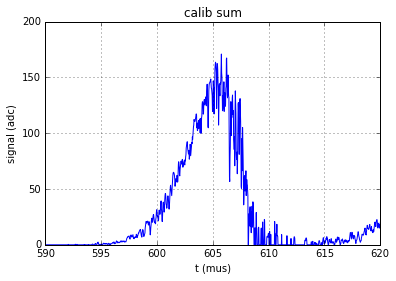

In [127]:
mpl.plot_signal(signal_t/units.mus, csum, title="csum",
                signal_start=590, signal_end=620, 
                ymax = 200, 
                t_units='mus', units="adc")

#### NB: This is a single waveform, but it will be sliced in more than one if the holes are too big. The S2 algorithm takes a stride of 1 mus.  With n_MAU=100 and  thr=5, holes are smaller than stride.

#### Run 2:  n_MAU=200, thr_MAU=5

In [129]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum, MAU, pmt_thr = calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=200, thr_MAU=5) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

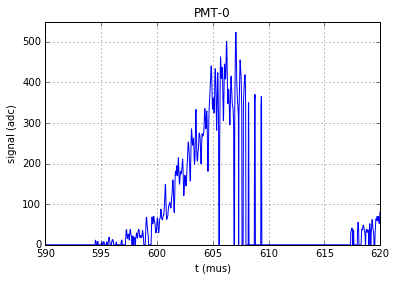

In [130]:
mpl.plot_signal(signal_t/units.mus, pmt_thr[0], title="PMT-0",
                signal_start=590, signal_end=620, 
                ymax = 550, 
                t_units='mus', units="adc")

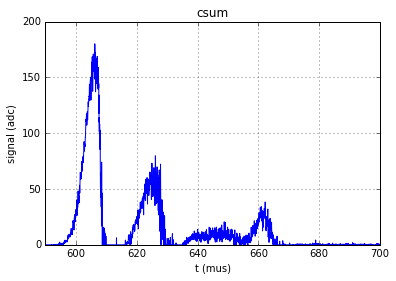

In [132]:
mpl.plot_signal(signal_t/units.mus, csum, title="csum",
                signal_start=590, signal_end=700, 
                ymax = 200, 
                t_units='mus', units="adc")

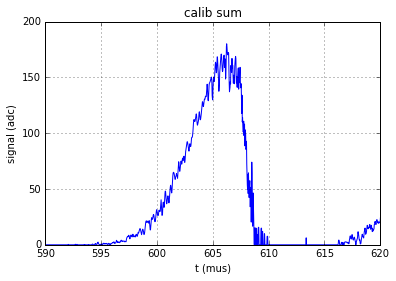

In [131]:
mpl.plot_signal(signal_t/units.mus, csum, title="calib sum",
                signal_start=590, signal_end=620, 
                ymax = 200, 
                t_units='mus', units="adc")

#### Here a hole can clearly be seen!

#### Run 3: n_MAU = 100, thr=3

In [139]:
event = 0
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum, MAU, pmt_thr = calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3*units.adc) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

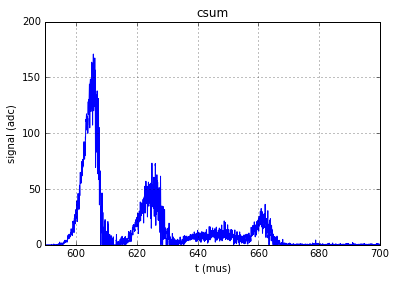

In [140]:
mpl.plot_signal(signal_t/units.mus, csum, title="csum",
                signal_start=590, signal_end=700, 
                ymax = 200, 
                t_units='mus', units="adc")

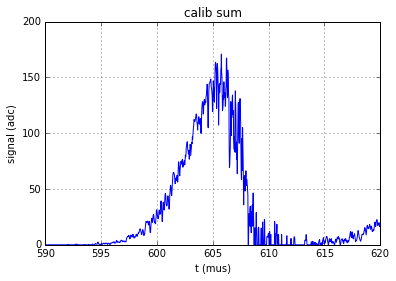

In [141]:
mpl.plot_signal(signal_t/units.mus, csum, title="calib sum",
                signal_start=590, signal_end=620, 
                ymax = 200, 
                t_units='mus', units="adc")

#### In conclussion: n_MAU = 100, thr_MAU=3*units.adc

### S1/S2

In [142]:
t0 = time()
for event in range(pmtrwf.shape[0]):
    
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
    csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3*units.adc) 
    wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
    wfzs_t = cpf.time_from_index(wfzs_indx)
    S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
    S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

t1 = time()        
dt = t1 - t0

print("run over {} events in {} s".format(event,dt))
print("time/event {} s".format(dt/event))

run over 90 events in 14.9693880081 s
time/event 0.166326533424 s


### SiPMs

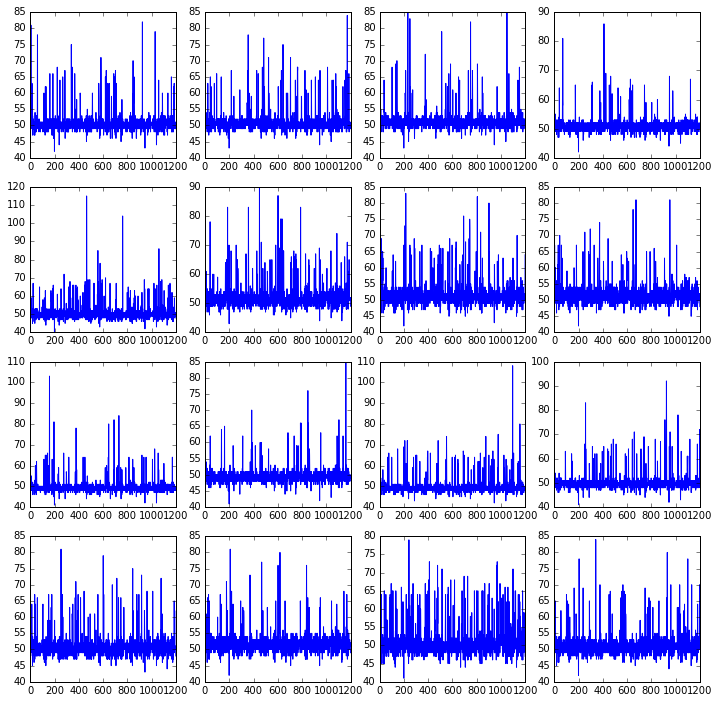

In [143]:
event=0
mpl.plot_sipm(sipmrwf[event], nmin=0, nmax=16, x=4, y=4)

### Subtract baseline, and set a cut to supress dark current

In [144]:
event=0
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=5*units.pes, n_MAU=100)

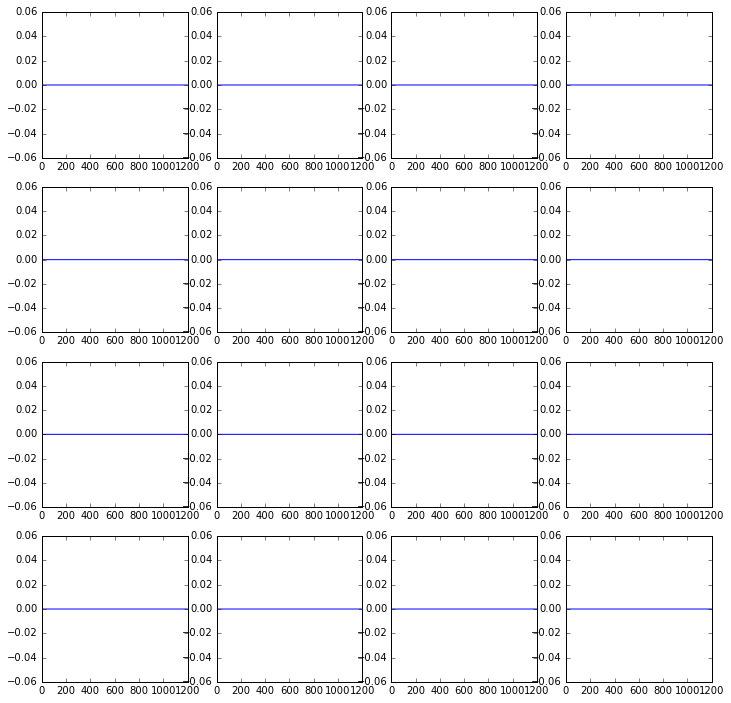

In [145]:
mpl.plot_sipm(sipm, nmin=0, nmax=16, x=4, y=4)

In [146]:
event=0
t0 = time()
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=5*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))
print('number of SiPM with signal = {}'.format(len(SIPM)))

run in 0.197691917419 s
number of SiPM with signal = 46


In [148]:
SIPM

{0: [192, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 1: [193, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 2: [195, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 3: [200, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 4: [224, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 5: [225, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 6: [228, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 7: [229, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 8: [230, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 9: [236, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 10: [240, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 11: [241, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 12: [242, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 13: [243, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 14: [244, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 15: [245, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 16: [246, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 17: [247, array([ 0.,  0.,  0., ...,  0.,  0.,  0.])],
 1

### PMAPS

#### Structure of a PMAP
1. S1 and S2 are dictionaries: each dictionary index is one S1/S2 candidate. Each dictionary value is a list which contains two elements. Element [0] is a np vector of times, element[1] is a np vector of energies in pes.
2. S2Si is a dictionary. Each index correspond to the S2 index. Each value is a list, whose length is equal to the number of SiPM with no zero signal in the S2 window. The list has as a first element the SiPM index and as a second the energy of each SiPM in the S2 window. Time is not neeeded (comes with S2).

#### S2 window
1. Given an S2 (T,E), obtain the relevant index range. 
2. Given a vector with SIPMs (energies above threshold), returns
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)
3. Given a vector with SIPMs (energies above threshold), and a 
    dictionary of S2s, S2d, returns a dictionary of SiPMs-S2.
    Each index of the dictionary correspond to one S2 and is
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)

In [149]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)

t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.187282085419 s


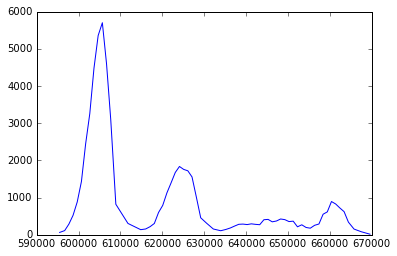

In [150]:
plt.plot(S2[0][0],S2[0][1])

In [151]:
S2

{0: [array([ 595485.        ,  596687.5       ,  597687.5       ,
          598687.5       ,  599687.5       ,  600687.5       ,
          601687.5       ,  602687.5       ,  603687.5       ,
          604687.5       ,  605687.5       ,  606687.5       ,
          607688.75      ,  608909.375     ,  611806.875     ,
          614851.25      ,  616041.875     ,  617112.5       ,
          618112.5       ,  619112.5       ,  620112.5       ,
          621112.5       ,  622112.5       ,  623112.5       ,
          624112.5       ,  625112.5       ,  626112.5       ,
          627112.5       ,  628148.75      ,  629190.        ,
          630575.625     ,  632205.625     ,  633978.75      ,
          635211.25      ,  636287.5       ,  637287.5       ,
          638287.5       ,  639287.5       ,  640287.5       ,
          641287.5       ,  642287.5       ,  643287.5       ,
          644287.5       ,  645287.5       ,  646287.5       ,
          647287.5       ,  648287.5       ,  649287

### Selecting SiPMs: threshold on the window 

#### NB: the sipm_S2 algorithm requires that the sum of energy in the S2 window for the SiPMs is above a threshold.
1. The SIPM vector has already been selected with a minimum cut (tipically 5 pes) to eliminate dark current.
2. After that cut, there will be a number of SiPMs which still have a random signal, due to dark current in the S2 window.
3. Those events, however, tend to have total areas close to the threshold, while genuine SiPMs with signal will have a larger area. 

#### Case 1: A low threshold 

In [154]:
sipml = pf.sipm_S2(SIPM,S2[0], thr=5*units.pes)

In [153]:
sipml

[[192, array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  6.4555223 ,
          5.78171704,  0.        ,  0.        ,  5.95016836,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        

In [176]:
def sipm_area_S2(sipml):
    """
    Computes and histgram the area in S2 window for SiPMs selected in sipml
    """
    area_s2 = np.zeros(len(sipml), dtype=np.double)
    for i, sipm in enumerate(sipml):
        area_s2[i] = np.sum(sipm[1])
    return area_s2

In [183]:
sipml[10][1]

array([  0.        ,   0.        ,   5.50152925,   6.53538813,
        10.02466184,  26.30793917,  24.36945378,  32.83417334,
        40.84657965,  34.83727492,  40.71734729,  40.26503403,
        30.31414233,  21.0740286 ,  13.44931938,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [190]:
def sipm_connected_S2(sipm):
    """
    Computes the number of connected bins in S2 window for one sipm
    """
    
    peak = sipm[1]    
    s = []
    for j in range(0,len(peak)-1):
        nc = 0
        for k in range(j+1, len(peak)):
            if peak[k] > 0:
                nc+=1
            else:
                s.append(nc)
                break
    
    return max(s)
            

In [191]:
sipm_connected_S2(sipml[10])

13

In [193]:
def sipm_list_connected_S2(sipml):
    """
    Computes the number of connected bins in S2 window for SiPMs selected in sipml
    """
    c_s2 = np.zeros(len(sipml), dtype=np.int)
    for i, sipm in enumerate(sipml):
        c_s2[i] = sipm_connected_S2(sipm)
        
    return c_s2

In [194]:
c_s2 = sipm_list_connected_S2(sipml)

(array([ 9.,  6.,  0.,  5.,  0.,  2.,  1.,  0.,  4.,  0.,  1.,  4.,  0.,
         2.,  0.,  1.,  5.,  0.,  2.,  3.]),
 array([  1. ,   1.6,   2.2,   2.8,   3.4,   4. ,   4.6,   5.2,   5.8,
          6.4,   7. ,   7.6,   8.2,   8.8,   9.4,  10. ,  10.6,  11.2,
         11.8,  12.4,  13. ]),
 <a list of 20 Patch objects>)

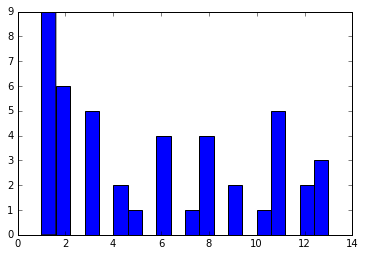

In [195]:
plt.hist(c_s2, bins=20)

In [166]:
area_s2 = sipm_area_S2(sipml)

(array([ 7.,  1.,  2.,  2.,  3.,  0.,  2.,  0.,  2.,  3.,  0.,  2.,  2.,
         0.,  0.,  2.,  0.,  0.,  0.,  2.]),
 array([  5.23879427,   9.66471032,  14.09062637,  18.51654242,
         22.94245847,  27.36837452,  31.79429057,  36.22020662,
         40.64612268,  45.07203873,  49.49795478,  53.92387083,
         58.34978688,  62.77570293,  67.20161898,  71.62753503,
         76.05345108,  80.47936713,  84.90528319,  89.33119924,  93.75711529]),
 <a list of 20 Patch objects>)

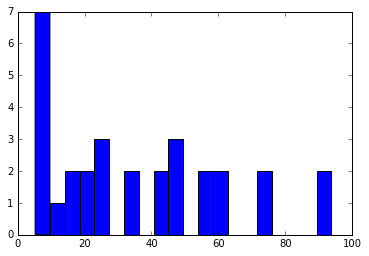

In [170]:
plt.hist(area_s2[area_s2<100], bins=20)

(array([ 3.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  3.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([ 105.35172073,  116.43797828,  127.52423583,  138.61049338,
         149.69675092,  160.78300847,  171.86926602,  182.95552357,
         194.04178112,  205.12803867,  216.21429622,  227.30055377,
         238.38681132,  249.47306887,  260.55932642,  271.64558397,
         282.73184152,  293.81809907,  304.90435662,  315.99061417,
         327.07687172]),
 <a list of 20 Patch objects>)

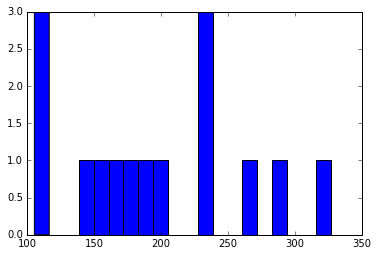

In [171]:
plt.hist(area_s2[area_s2>100], bins=20)

(array([ 11.,   6.,   5.,   4.,   2.,   2.,   3.,   0.,   2.,   1.,   1.,
          2.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,   1.]),
 array([   5.23879427,   21.33069814,   37.42260201,   53.51450588,
          69.60640976,   85.69831363,  101.7902175 ,  117.88212137,
         133.97402525,  150.06592912,  166.15783299,  182.24973686,
         198.34164074,  214.43354461,  230.52544848,  246.61735235,
         262.70925623,  278.8011601 ,  294.89306397,  310.98496784,
         327.07687172]),
 <a list of 20 Patch objects>)

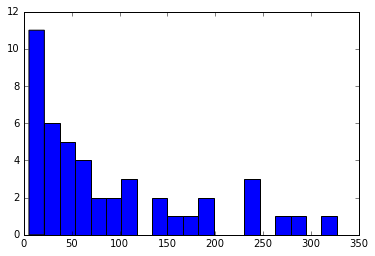

In [172]:
plt.hist(area_s2, bins=20)

#### NB, the exponential up to ~80 pes. These are all probably fake signals dure to dark current. The area depends of the S2 window. In this case

In [174]:
len(S2[0][1])

66

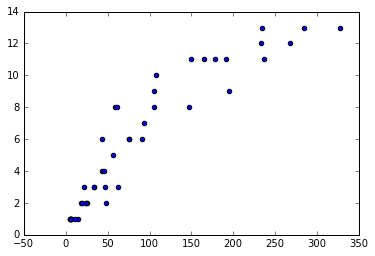

In [196]:
plt.scatter(area_s2,c_s2)

### Case 2: cut away the exponential background

In [197]:
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=50*units.pes)

In [198]:
sipmd

{0: [[224, array([  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            7.40914484,   8.65594213,   7.6585043 ,   6.72340633,
            7.28446511,   8.40658267,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   6.10000769,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
  

In [199]:
event = 0
t0 = time()
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=50*units.pes)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.000427961349487 s


### The full pre-proc 

In [200]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=590*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=5*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
sipmd = pf.sipm_S2_dict(SIPM, S2, thr=50*units.pes)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.487494945526 s


#### Plot SiPMs

In [35]:
len(DataSiPM)

1792

In [201]:
sipml =sipmd[0]

In [202]:
sipml[0]

[224, array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          7.40914484,   8.65594213,   7.6585043 ,   6.72340633,
          7.28446511,   8.40658267,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   6.10000769,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,

In [203]:
sipml[1]

[229, array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          5.97313481,  10.25307935,  10.85588844,  11.63954026,
          9.77083208,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          7.41987663,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,

In [204]:
def plot_ene_sipm(sipmd, Xs, Ys, radius=3):
    """
    plots the reconstructed energy of the SiPMs
    input: sipm dictionary
    """

    r = np.ones(len(Xs)) * radius
    col = np.zeros(len(Xs))
    for i in sipmd.keys():
        sipml = sipmd[i]
        for sipm in sipml:
            sipm_n = sipm[0]
            sipm_wf = sipm[1]
            sipm_e = np.sum(sipm_wf)
            col[sipm_n] = sipm_e

    plt.figure(figsize=(10, 10))
    plt.subplot(aspect="equal")
    mpl.circles(Xs, Ys, r, c=col, alpha=0.5, ec="none")
    plt.colorbar()

    plt.xlim(-198, 198)
    plt.ylim(-198, 198)
    
    return col

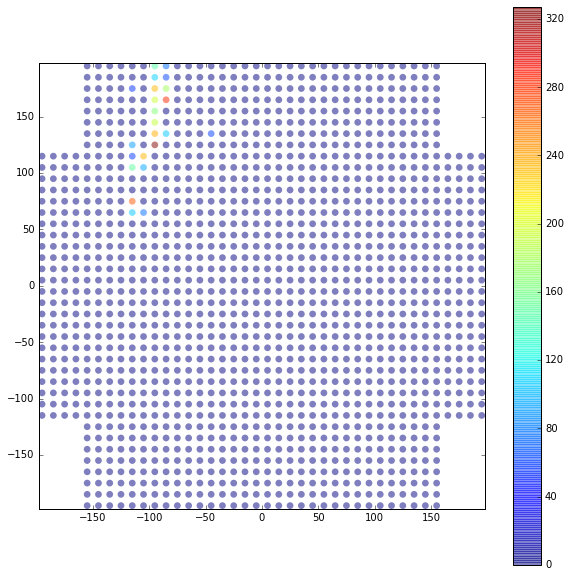

In [205]:
col = plot_ene_sipm(sipmd,xs,ys)

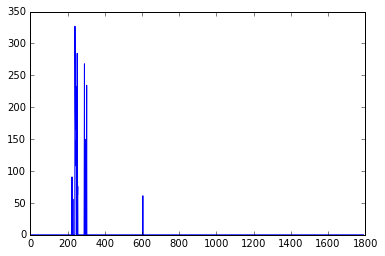

In [206]:
plt.plot(col)

### IRENE 

In [213]:
class Irene:
    """
    The city of IRENE performs a fast processing directly 
    from raw data (pmtrwf and sipmrwf) to PMAPS. 
    It is optimized for speed (use of CYTHON functions) and intended 
    for fast processing of data 

    """
    def __init__(self, run_number):
        """
        Inits the machine with the run number
        loads the data base to access calibration and geometry
        sets all switches to default value (False most of the time)
        """
        DataPMT = loadDB.DataPMT(run_number)
        DataSiPM = loadDB.DataSiPM(run_number)

        self.adc_to_pes = abs(DataPMT.adc_to_pes.values).astype(np.double)
        self.sipm_adc_to_pes = DataSiPM.adc_to_pes.values.astype(np.double)
        self.coeff_c = DataPMT.coeff_c.values.astype(np.double)
        self.coeff_blr = DataPMT.coeff_blr.values.astype(np.double)
        self.xs = DataSiPM.X.values
        self.ys = DataSiPM.Y.values
        
        self.setFiles = False
        self.setBLR = False
        self.setMAU = False
        self.setCSUM = False
        self.setS1 = False
        self.setS2 = False
        self.setSiPM = False

        self.plot_csum = False
        self.plot_s1 = False
        self.plot_s2 = False
        self.plot_sipm = False
        self.plot_sipmzs = False
        self.plot_simap = False
        
        self.nprint = 1000000

        # Dictionary of S1, S2 and SiPMs
        
        self.dS1 = {}
        self.dS2 = {}
        self.dSiPM = {}

    def set_plot(self, plot_csum=False, plot_s1=False, plot_s2=False, 
                 plot_sipm=False, plot_sipmzs=False, plot_simap=False):
        """
        decides what to plot
        """
        
        self.plot_csum = plot_csum
        self.plot_s1 = plot_s1
        self.plot_s2 = plot_s2
        self.plot_sipm = plot_sipm
        self.plot_sipmzs = plot_sipmzs
        self.plot_simap = plot_simap

    def set_print(self, nprint=10):
        """
        print frequency
        """
        self.nprint = nprint

    def set_files(self,path, input_files):
        """
        Sets the input files
        """
        self.path = path
        self.input_files = input_files
        self.setFiles = True

    def set_blr(self, n_baseline=38000, thr_trigger=5*units.adc):
        """
        Parameters of the BLR
        """
        self.n_baseline = n_baseline
        self.thr_trigger = thr_trigger
        self.setBLR = True
    
    def set_MAU(self, n_MAU=100, thr_MAU=3*units.adc):
        """
        Parameters of the MAU used to remove low frequency noise
        """
        self.n_MAU =  n_MAU
        self.thr_MAU = thr_MAU
        self.setMAU = True
    
    def set_csum(self, thr_csum=1*units.pes):
        """
        Parameter for ZS in the calibrated sum
        """
        self.thr_csum= thr_csum
        self.setCSUM = True

    def set_s1(self, tmin=0*units.mus, tmax=590*units.mus, 
               stride=4, lmin=4, lmax=20):
        """
        Parameters for S1 search
        """
        self.tmin_s1 = tmin
        self.tmax_s1 = tmax
        self.stride_s1 = stride
        self.lmin_s1 = lmin
        self.lmax_s1 = lmax
        self.setS1 = True

    def set_s2(self, tmin=590*units.mus, tmax=620*units.mus, 
               stride=40, lmin=100, lmax=1000000):
        """
        Parameters for S2 search
        """
        self.tmin_s2 = tmin
        self.tmax_s2 = tmax
        self.stride_s2 = stride
        self.lmin_s2 = lmin
        self.lmax_s2 = lmax
        self.setS2 = True
    
    def set_sipm(self, thr_zs=5*units.pes, thr_sipm_s2=50*units.pes):
        """
        Parameters for SiPM analysis
        """
        self.thr_zs = thr_zs
        self.thr_sipm_s2 = thr_sipm_s2
        self.setSiPM = True

    def get_dS1(self):
        """
        returns the S1 found (index count event number)
        """
        if len(self.dS1) == 0:
            print('S1 dictionary is empty')
            return 0
        else:
            return self.dS1

    def get_dS2(self):
        """
        returns the S2 found (index count event number)
        """
        if len(self.dS2) == 0:
            print('S2 dictionary is empty')
            return 0
        else:
            return self.dS2
    
    def get_dSiPM(self):
        """
        Returns the SiPMs found in S2 window (index count event number)
        """
        if len(self.dSiPM) == 0:
            print('S2 dictionary is empty')
            return 0
        else:
            return self.dSiPM

    def plot_ene_sipm(self,sipmd, radius=3):
        """
        plots the reconstructed energy of the SiPMs
        input: sipm dictionary
        """
    
        r = np.ones(len(self.xs)) * radius
        col = np.zeros(len(self.xs))
        for i in sipmd.keys():
            sipml = sipmd[i]
            for sipm in sipml:
                sipm_n = sipm[0]
                sipm_wf = sipm[1]
                sipm_e = np.sum(sipm_wf)
                col[sipm_n] = sipm_e

        plt.figure(figsize=(10, 10))
        plt.subplot(aspect="equal")
        mpl.circles(self.xs, self.ys, r, c=col, alpha=0.5, ec="none")
        plt.colorbar()

        plt.xlim(-198, 198)
        plt.ylim(-198, 198)

    def run(self, nmax):
        """
        Run the machine
        nmax is the max number of events to run

        """
        n_events_tot = 0

        # check that all switches are on
        
        if self.setFiles == False:
            raise IOError('must set files before running')
        if self.setBLR == False:
            raise IOError('must set BLR parameters before running')
        if self.setMAU == False:
            raise IOError('must set MAU parameters before running')
        if self.setCSUM == False:
            raise IOError('must set MAU parameters before running')
        if self.setS1 == False:
            raise IOError('must set S1 parameters before running')
        if self.setS2 == False:
            raise IOError('must set S2 parameters before running')
        if self.setSiPM == False:
            raise IOError('must set Sipm parameters before running')
        if self.path =='':
            raise IOError('path is empty')
        if len(self.input_files) == 0:
            raise IOError('input file list is empty')

        first=False
        for ffile in self.input_files:

            print("Opening", ffile, end="... ")
            filename = self.path + ffile
            #sys.stdout.flush()

            try:
                with tb.open_file(filename, "r+") as h5in:
                    pmtrwf = h5in.root.RD.pmtrwf
                    sipmrwf = h5in.root.RD.sipmrwf
                    
                    if first == False:
                    
                        self.NEVT, self.NPMT, self.PMTWL = pmtrwf.shape
                        NEVT, self.NSIPM, self.SIPMWL = sipmrwf.shape
                    
                        print("""
                        Number of events in file = {}
                        Number of PMTs = {}
                        PMTWL = {}
                        Number of SiPMs = {}
                        SiPMWL = {}
                          """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))
                        self.signal_t = np.arange(0., PMTWL * 25, 25)
                        first = True


                    for evt in range(self.NEVT):
                        # deconvolve
                        CWF = blr.deconv_pmt(pmtrwf[evt], 
                                             self.coeff_c, self.coeff_blr,
                                             n_baseline=self.n_baseline,
                                             thr_trigger=self.thr_trigger)

                        # calibrated PMT sum
                        csum = cpf.calibrated_pmt_sum(CWF, 
                                                      self.adc_to_pes,
                                                      n_MAU=self.n_MAU,
                                                      thr_MAU=self.thr_MAU)
                        if self.plot_csum:
                            mpl.plot_signal(self.signal_t/units.mus, 
                                            csum, title="calibrated sum, ZS",
                                            signal_start=0, signal_end=1200, 
                                            ymax = 200, 
                                            t_units='mus', units="pes")
                           
                            plt.show()
                            raw_input('->')


                        # Supress samples below threshold (in pes)
                        wfzs_ene, wfzs_indx = cpf.wfzs(csum, 
                                                       threshold=self.thr_csum)
                        
                        #wfzs_t = cpf.time_from_index(wfzs_indx)
                        
                        # find S1 and S2
                        S1 = cpf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s1,
                                         tmax=self.tmax_s1,
                                         lmin=self.lmin_s1, lmax=self.lmax_s1,
                                         stride=self.stride_s1, 
                                         rebin=False)

                        S2 = cpf.find_S12(wfzs_ene, wfzs_indx,
                                         tmin=self.tmin_s2,
                                         tmax=self.tmax_s2,
                                         lmin=self.lmin_s2, lmax=self.lmax_s2,
                                         stride=self.stride_s2,
                                         rebin=True, 
                                         rebin_stride=self.stride_s2)
                        
                        self.dS1[n_events_tot] = S1
                        self.dS2[n_events_tot] = S2

                        if self.plot_s1:
                            pf.scan_S12(S1)
                        if self.plot_s2:
                            pf.scan_S12(S2)
                        
                        # sipms
                        
                        if self.plot_sipm:
                            mpl.plot_sipm(sipmrwf[evt], nmin=0, nmax=16, x=4, y=4)
                            
                        sipmzs = cpf.signal_sipm(sipmrwf[evt], 
                                                 self.sipm_adc_to_pes, 
                                                 thr=self.thr_zs, 
                                                 n_MAU=self.n_MAU)
                        if self.plot_sipmzs:
                            mpl.plot_sipm(sipmzs, nmin=0, nmax=16, x=4, y=4)
                            plt.show()
                            raw_input('->')
                        
                        SIPM = cpf.select_sipm(sipmzs)
                        sipmd = pf.sipm_S2_dict(SIPM, S2, thr=self.thr_sipm_s2)
                        self.dSiPM[n_events_tot] = sipmd
                        
                        if self.plot_simap:
                            self.plot_ene_sipm(sipmd)
                            plt.show()
                            raw_input('->')
                        
                        n_events_tot +=1
                        if n_events_tot%self.nprint == 0:
                            print('event in file = {}, total = {}'.format(evt, 
                                                                          n_events_tot))

                        if n_events_tot >= nmax:
                            print('reached maximum number of events (={})'.format(nmax))
                            return nmax


            except:
                print('error')
                raise
        
        return n_events_tot



### Run Irene

In [210]:
input_files =['run_2976.gdc1next.000.next1el_2976.root.h5']
path='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/run2976/'

### Run with control plots

Opening run_2976.gdc1next.000.next1el_2976.root.h5... 
                        Number of events in file = 91
                        Number of PMTs = 12
                        PMTWL = 48000
                        Number of SiPMs = 1792
                        SiPMWL = 1200
                          


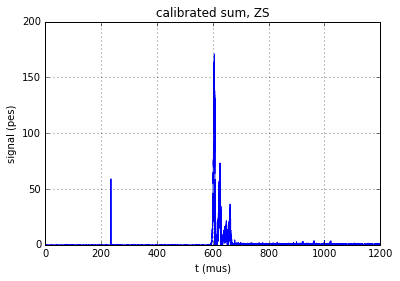

->
number of peaks = 1
S12 number = 0, samples = 16 sum in pes =348.449967486


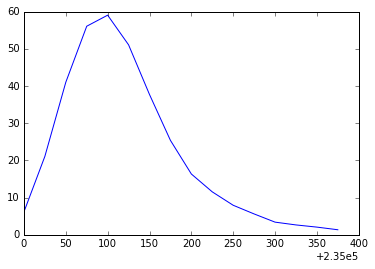

hit return
number of peaks = 1
S12 number = 0, samples = 66 sum in pes =60459.7899095


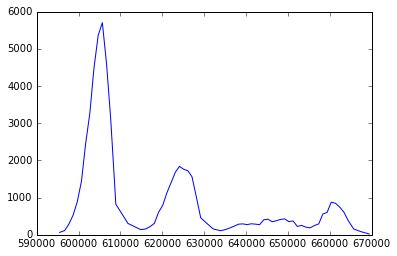

hit return


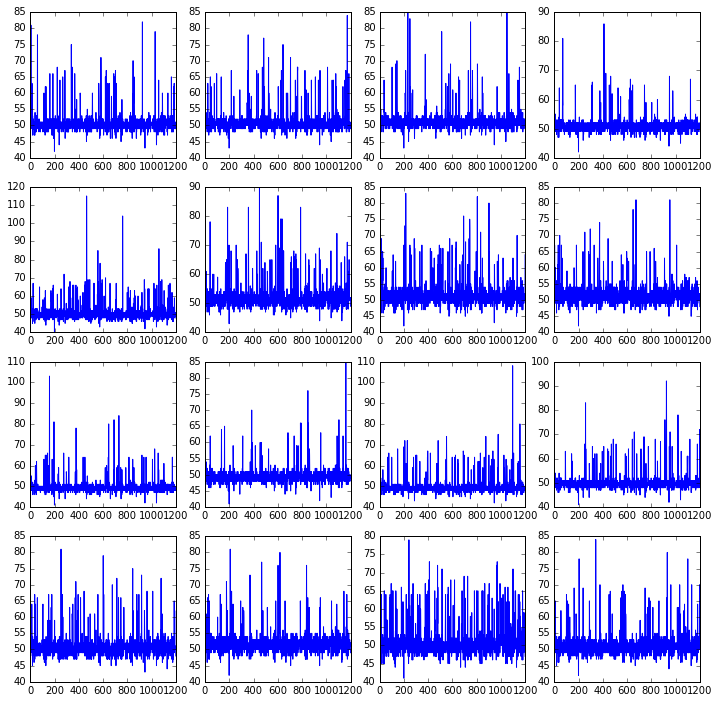

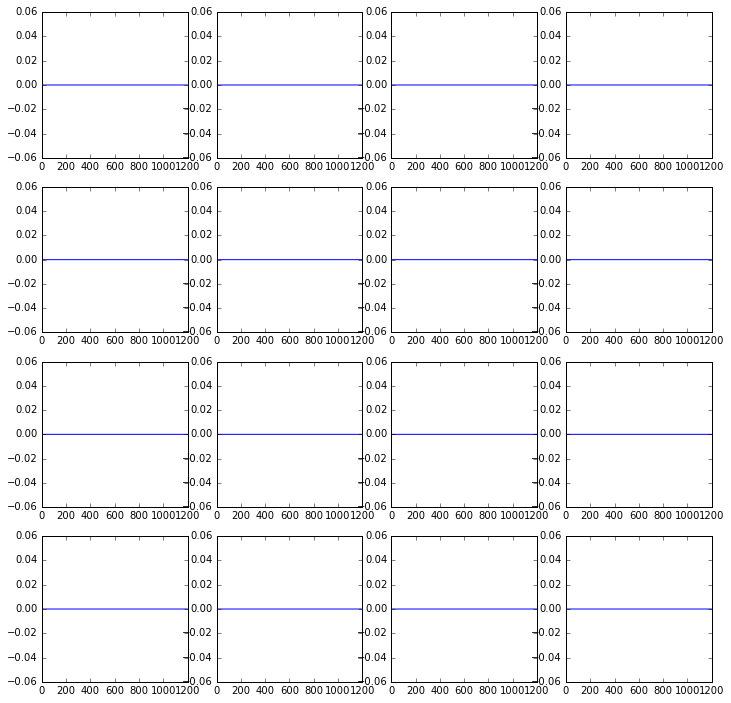

->


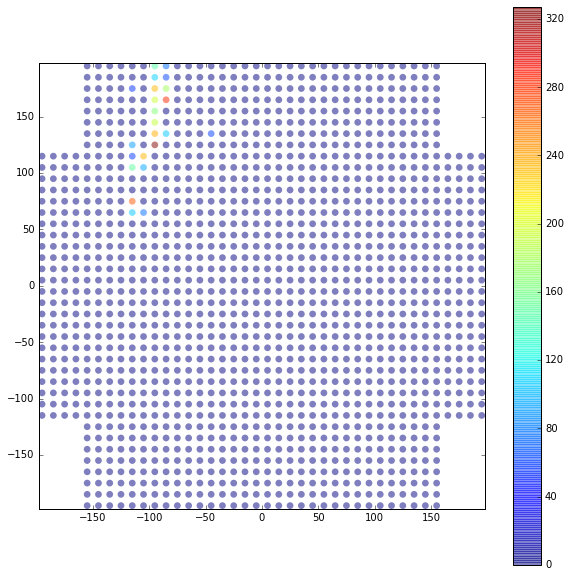

->
event in file = 0, total = 1
reached maximum number of events (=1)


1

In [211]:
# instance
fpp = Irene(run_number=2976)

# set the state of the machine
fpp.set_files(path, input_files) 
fpp.set_plot(plot_csum=True, plot_s1=True, plot_s2=True, 
             plot_sipm=True, plot_sipmzs=True, plot_simap=True)
fpp.set_print(nprint=1)
fpp.set_blr(n_baseline=38000, thr_trigger=5*units.adc)
fpp.set_MAU(n_MAU=100, thr_MAU=3*units.adc)
fpp.set_csum(thr_csum=1*units.pes)
fpp.set_s1(tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
fpp.set_s2(tmin=590*units.mus, tmax=1190*units.mus, stride=40, lmin=100, 
           lmax=100000)
fpp.set_sipm(thr_zs=5*units.pes, thr_sipm_s2=50*units.pes)

# run
fpp.run(nmax=1)

### Run with plots off

In [214]:
# instance
fpp = Irene(run_number=2976)

# set the state of the machine
fpp.set_files(path, input_files) 
# plots are False by default
#fpp.set_plot(plot_csum=True, plot_s1=True, plot_s2=True, 
#             plot_sipm=True, plot_sipmzs=True, plot_simap=True)
fpp.set_print(nprint=1)
fpp.set_blr(n_baseline=38000, thr_trigger=5*units.adc)
fpp.set_MAU(n_MAU=100, thr_MAU=3*units.adc)
fpp.set_csum(thr_csum=1*units.pes)
fpp.set_s1(tmin=10*units.mus, tmax=590*units.mus, stride=4, lmin=8, lmax=20)
fpp.set_s2(tmin=590*units.mus, tmax=1190*units.mus, stride=40, lmin=100, 
           lmax=100000)
fpp.set_sipm(thr_zs=5*units.pes, thr_sipm_s2=50*units.pes)

# run
t0 = time()
fpp.run(nmax=1)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

Opening run_2976.gdc1next.000.next1el_2976.root.h5... 
                        Number of events in file = 91
                        Number of PMTs = 12
                        PMTWL = 48000
                        Number of SiPMs = 1792
                        SiPMWL = 1200
                          
event in file = 0, total = 1
reached maximum number of events (=1)
run in 0.374479055405 s


### Get S1, S2, SiPM

In [215]:
t0 = time()
dS1 = fpp.get_dS1()
dS2 = fpp.get_dS2()
dSiPM = fpp.get_dSiPM()
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))

run in 0.000264883041382 s


In [216]:
dS1

{0: {0: [array([ 235000.,  235025.,  235050.,  235075.,  235100.,  235125.,
           235150.,  235175.,  235200.,  235225.,  235250.,  235275.,
           235300.,  235325.,  235350.,  235375.]),
   array([  6.16521547,  21.08811696,  41.00919263,  56.06795131,
           59.04096406,  51.0656867 ,  37.71387648,  25.38805561,
           16.34328591,  11.54164314,   7.93922203,   5.60765096,
            3.40379295,   2.65349753,   2.06578602,   1.35602972])]}}

In [217]:
dS1[0]

{0: [array([ 235000.,  235025.,  235050.,  235075.,  235100.,  235125.,
          235150.,  235175.,  235200.,  235225.,  235250.,  235275.,
          235300.,  235325.,  235350.,  235375.]),
  array([  6.16521547,  21.08811696,  41.00919263,  56.06795131,
          59.04096406,  51.0656867 ,  37.71387648,  25.38805561,
          16.34328591,  11.54164314,   7.93922203,   5.60765096,
           3.40379295,   2.65349753,   2.06578602,   1.35602972])]}

In [218]:
dS2[0]

{0: [array([ 595485.        ,  596687.5       ,  597687.5       ,
          598687.5       ,  599687.5       ,  600687.5       ,
          601687.5       ,  602687.5       ,  603687.5       ,
          604687.5       ,  605687.5       ,  606687.5       ,
          607688.75      ,  608909.375     ,  611806.875     ,
          614851.25      ,  616041.875     ,  617112.5       ,
          618112.5       ,  619112.5       ,  620112.5       ,
          621112.5       ,  622112.5       ,  623112.5       ,
          624112.5       ,  625112.5       ,  626112.5       ,
          627112.5       ,  628148.75      ,  629190.        ,
          630575.625     ,  632205.625     ,  633960.        ,
          635182.5       ,  636262.5       ,  637262.5       ,
          638262.5       ,  639262.5       ,  640262.5       ,
          641262.5       ,  642262.5       ,  643262.5       ,
          644262.5       ,  645262.5       ,  646262.5       ,
          647262.5       ,  648262.5       ,  649262

In [219]:
dSiPM[0]

{0: [[224, array([  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            7.40914484,   8.65594213,   7.6585043 ,   6.72340633,
            7.28446511,   8.40658267,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   6.10000769,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
  